In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

In [3]:
## noise, generator and discriminator
def get_noise(n_samples, input_dim, device='cuda'):
  
    return torch.randn(n_samples, input_dim, device=device)

class Generator(nn.Module):
   
    def __init__(self, input_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
    
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
      
        x = noise.view(len(noise), self.input_dim, 1, 1) ## unsqueeze
        return self.gen(x)
    
class Discriminator(nn.Module):

    def __init__(self, im_chan=1, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
      
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [4]:
## one-hot vectors
def get_one_hot_labels(labels, n_classes):
  
    return F.one_hot(labels, n_classes)

def combine_vectors(x, y):
    return torch.cat((x.float(), y.float()), 1)

In [5]:
## training parameters
mnist_shape = (1, 28, 28)
n_classes = 10
criterion = nn.BCEWithLogitsLoss()
n_epochs = 100
z_dim = 64
display_step = 20000
batch_size = 128
lr = 0.0002
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=False, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [6]:
## a function to update gen and disc initialization
def get_input_dimensions(z_dim, mnist_shape, n_classes):
    generator_input_dim = z_dim + n_classes
    discriminator_input_dim = mnist_shape[0] + n_classes
    return generator_input_dim, discriminator_input_dim

In [7]:
# gen and disc inintialization
generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, mnist_shape, n_classes)

gen = Generator(input_dim=generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(im_chan=discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

## for normalizing the parameters of each layer
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Epoch 42, step 20000: Generator loss: 1.820169827708602, discriminator loss: 0.4357021732390742


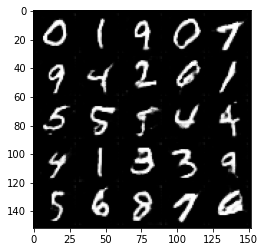

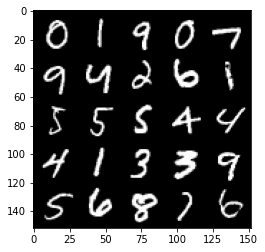

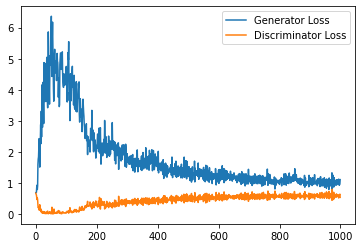

Epoch 85, step 40000: Generator loss: 0.9612928364247084, discriminator loss: 0.6117800718441606


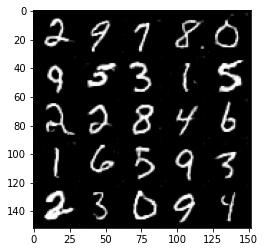

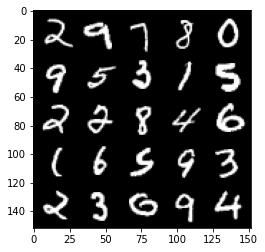

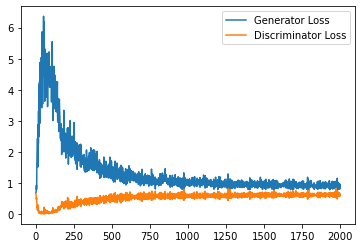

In [21]:
## actual training
cur_step = 0
generator_losses = []
discriminator_losses = []

for epoch in range(n_epochs):
    for real, labels in (dataloader):
        cur_batch_size = len(real)
        # flatten the batch of real images:
        real = real.to(device)
        
        one_hot_labels = get_one_hot_labels(labels.to(device), n_classes)
        ## create one hot label for images:
        image_one_hot_label = one_hot_labels[:,:,None,None]
        image_one_hot_label = image_one_hot_label.repeat(1,1, mnist_shape[1], mnist_shape[2])
        
        # disc:
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        one_hot_noise = combine_vectors(fake_noise, one_hot_labels)
        fake_image = gen(one_hot_noise)
        
        # combine image with one-hot labels
        fake_image_one_hot = combine_vectors(fake_image, image_one_hot_label)
        real_image_one_hot = combine_vectors(real, image_one_hot_label)
        disc_fake_pred = disc(fake_image_one_hot.detach())
        disc_real_pred = disc(real_image_one_hot)
        
        disc_fake_loss= criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        
        # keep track of avg. disc loss
        discriminator_losses += [disc_loss.item()]
        
        
        # generator
        gen_opt.zero_grad()
        fake_image_and_labels = combine_vectors(fake_image, image_one_hot_label)
        disc_fake_pred = disc(fake_image_and_labels)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()
        
        # keep track of generator loss
        generator_losses += [gen_loss.item()]
        
        
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            show_tensor_images(fake_image)
            show_tensor_images(real)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
        # if cur_step % display_step == 0 and cur_step > 0:
        #     print(f'cur_step: {cur_step}, epoch: {epoch}')
        
        cur_step += 1

In [49]:
gen.eval()

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(74, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
      (1): Tanh()
    )
  )
)

In [36]:
## save generator and discriminator
torch.save(gen.state_dict(), './saved_models/generator/gen.pth')

In [45]:
torch.save(disc.state_dict(), './saved_models/discriminator/disc.pth')

In [8]:
gen = Generator(input_dim=generator_input_dim).to(device)
gen.load_state_dict(torch.load('./saved_models/generator/gen.pth'))
gen.eval()

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(74, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
      (1): Tanh()
    )
  )
)